In [13]:
import cv2
import os
import shutil

import os
import torch
from PIL import Image
from torchvision import transforms
from transformers import AutoImageProcessor, AutoModel
import numpy as np

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

## Extract frames

In [5]:
def extract_frames(video_path, output_dir='frames', frame_rate=1):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    video_capture = cv2.VideoCapture(video_path)
    fps = int(video_capture.get(cv2.CAP_PROP_FPS))
    frame_interval = int(fps / frame_rate)
    frame_count = 0
    frame_index = 0

    while True:
        ret, frame = video_capture.read()
        if not ret:
            break

        if frame_count % frame_interval == 0:
            frame_path = os.path.join(output_dir, f"frame_{frame_index:05d}.jpg")
            cv2.imwrite(frame_path, frame)
            frame_index += 1
        
        frame_count += 1

    video_capture.release()
    print(f"Frames extracted to {output_dir}")

# extract_frames('test.mp4', frame_rate=1)


## detect anime face

In [3]:
def detect(input_directory, output_directory, cascade_file="lbpcascade_animeface.xml"):
    if not os.path.isfile(cascade_file):
        raise RuntimeError("%s: not found" % cascade_file)

    cascade = cv2.CascadeClassifier(cascade_file)

    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')  # 有效的图像文件扩展名
    image_files = [f for f in os.listdir(input_directory) if f.lower().endswith(valid_extensions)]

    for img_file in image_files:
        img_path = os.path.join(input_directory, img_file)
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if image is None:
            print(f"Failed to load image {img_path}")
            continue

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.equalizeHist(gray)

        faces = cascade.detectMultiScale(
            gray,
            scaleFactor=1.1,
            minNeighbors=5,
            minSize=(24, 24)
        )

        for i, (x, y, w, h) in enumerate(faces):
            cropped = image[y:y + h, x:x + w]
            output_path = os.path.join(output_directory, f"{os.path.splitext(img_file)[0]}_face_{i}.png")
            success = cv2.imwrite(output_path, cropped)
            if success:
                print(f"Saved face {i} from {img_file} to {output_path}")
            else:
                print(f"Failed to save face {i} from {img_file}")

    print("Detection complete.")

# input_dir = "frames"
# output_dir = "face_cripped_output"
# detect(input_dir, output_dir, "lbpcascade_animeface.xml")


## extract embedding

In [42]:
import os
import torch
from PIL import Image
from torchvision import transforms
from transformers import AutoImageProcessor, AutoModel
import numpy as np

def extract_embeddings(input_dir, output_dir, model_name="facebook/dinov2-base"):
    """
    从图像中提取嵌入，并将其保存为txt文件。

    参数:
    - input_dir: str，输入图像文件夹路径
    - output_dir: str，输出嵌入文件夹路径
    - model_name: str，使用的预训练模型名称
    """
    
    # 加载模型和预处理器
    processor = AutoImageProcessor.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    # 如果输出文件夹不存在，则创建
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # 图像转换
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
    ])

    # 遍历输入文件夹中的所有图像
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
    for img_file in os.listdir(input_dir):
        if img_file.lower().endswith(valid_extensions):
            img_path = os.path.join(input_dir, img_file)
            image = Image.open(img_path).convert("RGB")
            image_tensor = transform(image).unsqueeze(0)

            # 使用模型提取嵌入
            with torch.no_grad():
                output = model(image_tensor)
                embedding = output.last_hidden_state.mean(dim=1).squeeze().numpy()

            # 保存嵌入到txt文件
            embedding_file = os.path.join(output_dir, f"{os.path.splitext(img_file)[0]}.txt")
            np.savetxt(embedding_file, embedding)
            print(f"Embedding for {img_file} saved to {embedding_file}")

extract_embeddings(input_dir="face_cripped_output", output_dir="embeddings")


Embedding for frame_02964_face_0.png saved to embeddings/frame_02964_face_0.txt
Embedding for frame_06454_face_1.png saved to embeddings/frame_06454_face_1.txt
Embedding for frame_02348_face_1.png saved to embeddings/frame_02348_face_1.txt
Embedding for frame_03094_face_0.png saved to embeddings/frame_03094_face_0.txt
Embedding for frame_06629_face_1.png saved to embeddings/frame_06629_face_1.txt
Embedding for frame_00452_face_0.png saved to embeddings/frame_00452_face_0.txt
Embedding for frame_03932_face_0.png saved to embeddings/frame_03932_face_0.txt
Embedding for frame_05607_face_0.png saved to embeddings/frame_05607_face_0.txt
Embedding for frame_01245_face_0.png saved to embeddings/frame_01245_face_0.txt
Embedding for frame_04745_face_0.png saved to embeddings/frame_04745_face_0.txt
Embedding for frame_01038_face_0.png saved to embeddings/frame_01038_face_0.txt
Embedding for frame_05713_face_0.png saved to embeddings/frame_05713_face_0.txt
Embedding for frame_03826_face_0.png sav

## crip and extract embedding of test_cel and test_image

In [6]:
cel_path = "cel"
cel_output_path = "cel_cripped"
detect(cel_path, cel_output_path)

Detection complete.


In [34]:
extract_embeddings(input_dir='cel_cripped', output_dir='cel_embedding')

Embedding for dgm049_face_0.jpg saved to cel_embedding/dgm049_face_0.txt
Embedding for dgm332_face_0.jpg saved to cel_embedding/dgm332_face_0.txt


## DBSCAN clustering

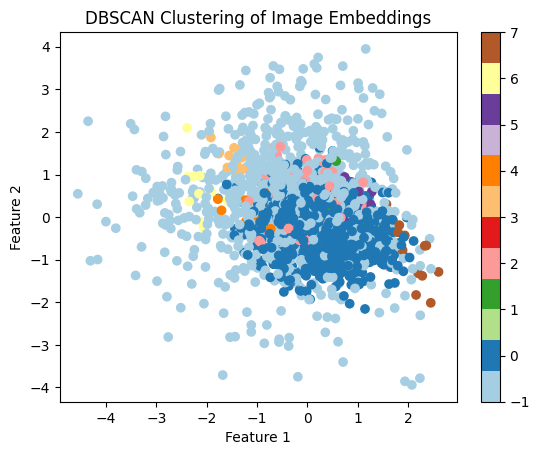

Cluster center for cluster -1 saved to DBSCAN_res/cluster_-1_center.txt
Cluster -1: 914 files saved to DBSCAN_res
Cluster center for cluster 0 saved to DBSCAN_res/cluster_0_center.txt
Cluster 0: 1010 files saved to DBSCAN_res
Cluster center for cluster 1 saved to DBSCAN_res/cluster_1_center.txt
Cluster 1: 10 files saved to DBSCAN_res
Cluster center for cluster 2 saved to DBSCAN_res/cluster_2_center.txt
Cluster 2: 88 files saved to DBSCAN_res
Cluster center for cluster 3 saved to DBSCAN_res/cluster_3_center.txt
Cluster 3: 10 files saved to DBSCAN_res
Cluster center for cluster 4 saved to DBSCAN_res/cluster_4_center.txt
Cluster 4: 15 files saved to DBSCAN_res
Cluster center for cluster 5 saved to DBSCAN_res/cluster_5_center.txt
Cluster 5: 10 files saved to DBSCAN_res
Cluster center for cluster 6 saved to DBSCAN_res/cluster_6_center.txt
Cluster 6: 10 files saved to DBSCAN_res
Cluster center for cluster 7 saved to DBSCAN_res/cluster_7_center.txt
Cluster 7: 13 files saved to DBSCAN_res
DBSC

In [43]:
import os
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import shutil

# Step 1: 读取所有嵌入
embeddings_dir = 'embeddings'  # 替换为实际路径
images_dir = 'face_cripped_output'  # 替换为对应的图像文件夹路径
embeddings = []
file_names = []

for file_name in os.listdir(embeddings_dir):
    if file_name.endswith('.txt'):
        file_path = os.path.join(embeddings_dir, file_name)
        embedding = np.loadtxt(file_path)
        embeddings.append(embedding)
        file_names.append(file_name)

embeddings = np.array(embeddings)

# Step 2: 标准化嵌入
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# Step 3: 执行 DBSCAN 聚类
dbscan = DBSCAN(eps=20, min_samples=8)  # 可以调整 eps 和 min_samples 参数
clusters = dbscan.fit_predict(embeddings_scaled)

# Step 4: 可视化结果（仅适用于2D或通过PCA降维到2D的情况）
plt.scatter(embeddings_scaled[:, 0], embeddings_scaled[:, 1], c=clusters, cmap='Paired', marker='o')
plt.title('DBSCAN Clustering of Image Embeddings')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar()
plt.show()

# Step 5: 将聚类结果的图片和嵌入分别保存到对应的文件夹中，并保存每个聚类的中心
output_dir = 'DBSCAN_res'  # 替换为实际路径
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for cluster_id in np.unique(clusters):
    cluster_dir = os.path.join(output_dir, f'cluster_{cluster_id}')
    embeddings_cluster_dir = os.path.join(cluster_dir, 'embeddings')
    images_cluster_dir = os.path.join(cluster_dir, 'images')
    
    os.makedirs(embeddings_cluster_dir, exist_ok=True)
    os.makedirs(images_cluster_dir, exist_ok=True)

    cluster_indices = np.where(clusters == cluster_id)[0]
    cluster_embeddings = []

    for index in cluster_indices:
        file_name = file_names[index]
        
        # 复制嵌入文件
        src_embedding_path = os.path.join(embeddings_dir, file_name)
        dst_embedding_path = os.path.join(embeddings_cluster_dir, file_name)
        shutil.copyfile(src_embedding_path, dst_embedding_path)

        # 保存聚类的嵌入数据以计算中心
        cluster_embeddings.append(embeddings_scaled[index])

        # 复制对应的图像文件
        image_file_name = file_name.replace('.txt', '.png')  # 替换扩展名
        src_image_path = os.path.join(images_dir, image_file_name)
        dst_image_path = os.path.join(images_cluster_dir, image_file_name)
        
        if os.path.exists(src_image_path):
            shutil.copyfile(src_image_path, dst_image_path)
        else:
            print(f"Image file not found for {file_name}")

    # 计算并保存聚类中心
    if len(cluster_embeddings) > 0:
        cluster_center = np.mean(cluster_embeddings, axis=0)
        cluster_center_file = os.path.join(output_dir, f'cluster_{cluster_id}_center.txt')
        np.savetxt(cluster_center_file, cluster_center)
        print(f"Cluster center for cluster {cluster_id} saved to {cluster_center_file}")

    print(f"Cluster {cluster_id}: {len(cluster_indices)} files saved to {output_dir}")

print("DBSCAN clustering and file sorting completed.")


In [44]:
import os
import numpy as np
from scipy.spatial.distance import cdist
import shutil

def load_cluster_centers(cluster_centers_dir):
    cluster_center_files = [f for f in os.listdir(cluster_centers_dir) if f.endswith('.txt')]
    cluster_centers = []
    for center_file in cluster_center_files:
        center_path = os.path.join(cluster_centers_dir, center_file)
        center = np.loadtxt(center_path)
        cluster_label = os.path.splitext(center_file)[0].replace('_center', '')
        cluster_centers.append((center, cluster_label))
    return cluster_centers

def assign_folder_to_clusters(embedding_folder, cluster_centers_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    cluster_centers = load_cluster_centers(cluster_centers_dir)
    cluster_labels = [f[1] for f in cluster_centers]
    cluster_centers = np.array([f[0] for f in cluster_centers])

    for embedding_file in os.listdir(embedding_folder):
        if embedding_file.endswith('.txt'):
            file_path = os.path.join(embedding_folder, embedding_file)

            # 加载嵌入
            new_embedding = np.loadtxt(file_path).reshape(1, -1)

            # 计算与每个聚类中心的距离
            distances = cdist(new_embedding, cluster_centers, metric='euclidean')
            closest_cluster_index = np.argmin(distances)
            closest_cluster_label = cluster_labels[closest_cluster_index]

            # 根据聚类结果保存嵌入文件
            cluster_dir = os.path.join(output_dir, closest_cluster_label)
            os.makedirs(cluster_dir, exist_ok=True)
            dst_embedding_path = os.path.join(cluster_dir, embedding_file)
            shutil.copyfile(file_path, dst_embedding_path)

            print(f"File {embedding_file} assigned to cluster {closest_cluster_label}.")

# 示例使用
new_embeddings_folder = 'cel_embedding'  # 替换为要分配的新嵌入文件夹路径
cluster_centers_dir = 'DBSCAN_res'  # 替换为聚类中心嵌入文件夹路径
assign_folder_to_clusters(new_embeddings_folder, cluster_centers_dir, output_dir="DBSCAN_assigned_clusters")


File dgm049_face_0.txt assigned to cluster cluster_0.
File dgm332_face_0.txt assigned to cluster cluster_0.


## K_means clustering

/Users/zhangzijun/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


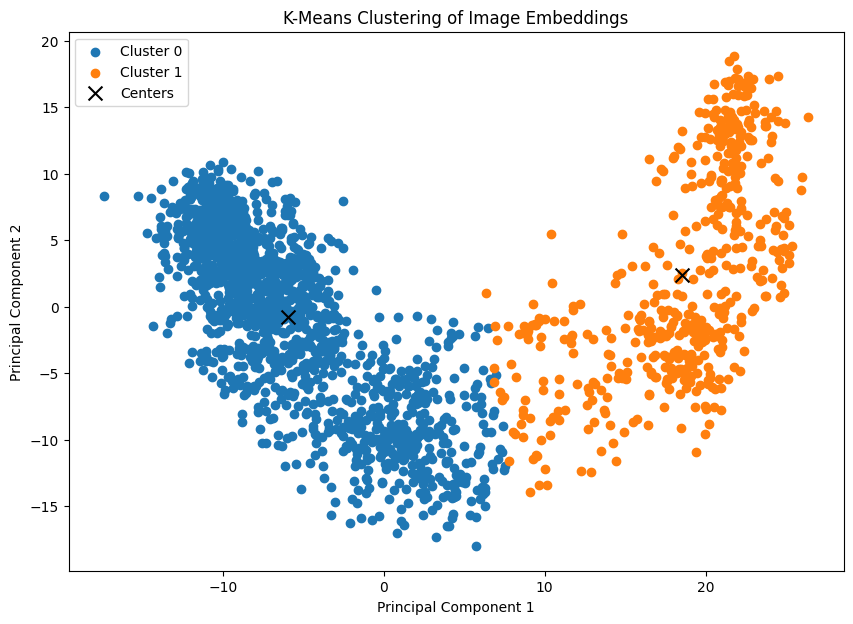

Cluster 0: 1576 items copied to k_means_first_clustered_output/cluster_0
Cluster 1: 504 items copied to k_means_first_clustered_output/cluster_1
Cluster center 0 saved to k_means_first_clustered_output/cluster_center_0.txt
Cluster center 1 saved to k_means_first_clustered_output/cluster_center_1.txt
Clustering and file copying completed.


In [45]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 设置嵌入文件夹路径和原图像文件夹路径
embedding_dir = "embeddings"  # 替换为嵌入文件夹路径
image_dir = "face_cripped_output"  # 替换为裁剪图像文件夹路径
output_cluster_dir = "k_means_first_clustered_output"  # 替换为聚类输出文件夹路径

# 创建输出文件夹
if not os.path.exists(output_cluster_dir):
    os.makedirs(output_cluster_dir)

# 加载嵌入
embeddings = []
file_names = []
for embedding_file in os.listdir(embedding_dir):
    if embedding_file.endswith(".txt"):
        embedding_path = os.path.join(embedding_dir, embedding_file)
        embedding = np.loadtxt(embedding_path)
        embeddings.append(embedding)
        file_names.append(os.path.splitext(embedding_file)[0])

embeddings = np.array(embeddings)

# 进行标准化处理
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# 使用PCA降维以便于可视化
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_scaled)

# 设置K-Means聚类的参数
num_clusters = 2  # 你可以调整聚类数量
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# 执行K-Means聚类
kmeans.fit(embeddings_scaled)
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

# 可视化聚类结果
plt.figure(figsize=(10, 7))
for i in range(num_clusters):
    cluster_indices = np.where(labels == i)[0]
    cluster_embeddings_2d = embeddings_2d[cluster_indices]
    plt.scatter(cluster_embeddings_2d[:, 0], cluster_embeddings_2d[:, 1], label=f'Cluster {i}')
plt.scatter(pca.transform(cluster_centers)[:, 0], pca.transform(cluster_centers)[:, 1], color='black', marker='x', s=100, label='Centers')
plt.legend()
plt.title("K-Means Clustering of Image Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# 创建每个聚类的文件夹并将嵌入和图像文件分别复制进去
for i in range(num_clusters):
    cluster_dir = os.path.join(output_cluster_dir, f"cluster_{i}")
    embedding_cluster_dir = os.path.join(cluster_dir, "embedding")
    image_cluster_dir = os.path.join(cluster_dir, "images")
    os.makedirs(embedding_cluster_dir, exist_ok=True)
    os.makedirs(image_cluster_dir, exist_ok=True)

    cluster_indices = np.where(labels == i)[0]
    for idx in cluster_indices:
        file_name = file_names[idx]

        # 复制嵌入文件
        src_embedding_path = os.path.join(embedding_dir, f"{file_name}.txt")
        dst_embedding_path = os.path.join(embedding_cluster_dir, f"{file_name}.txt")
        shutil.copyfile(src_embedding_path, dst_embedding_path)

        # 复制原图像文件
        src_image_path = os.path.join(image_dir, f"{file_name}.png")  # 假设图像扩展名为png，若有不同请更改
        dst_image_path = os.path.join(image_cluster_dir, f"{file_name}.png")
        if os.path.exists(src_image_path):
            shutil.copyfile(src_image_path, dst_image_path)

    print(f"Cluster {i}: {len(cluster_indices)} items copied to {cluster_dir}")

# 保存聚类中心到单独的文件
for i, center in enumerate(cluster_centers):
    center_file = os.path.join(output_cluster_dir, f"cluster_center_{i}.txt")
    np.savetxt(center_file, center)
    print(f"Cluster center {i} saved to {center_file}")

print("Clustering and file copying completed.")


### Based on Edge Detection to to determine which cluster contains anime faces

In [46]:
def calculate_edge_density(image_dir):
    """计算给定目录中所有图片的平均边缘密度."""
    total_edges = 0
    num_images = 0

    for img_file in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_file)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            edges = cv2.Canny(image, 100, 200)
            edge_density = np.sum(edges) / edges.size
            total_edges += edge_density
            num_images += 1

    if num_images > 0:
        average_edge_density = total_edges / num_images
    else:
        average_edge_density = 0

    return average_edge_density

# 储存每个聚类的边缘密度
cluster_edges = []

for i in range(num_clusters):
    image_cluster_dir = os.path.join(output_cluster_dir, f"cluster_{i}", "images")
    avg_edge_density = calculate_edge_density(image_cluster_dir)
    cluster_edges.append((i, avg_edge_density))
    print(f"Cluster {i} average edge density: {avg_edge_density}")

# 找到边缘密度较高的聚类
best_cluster = max(cluster_edges, key=lambda x: x[1])[0]
print(f"The cluster most likely to be anime faces is: cluster_{best_cluster}")




Cluster 0 average edge density: 19.464081264356427
Cluster 1 average edge density: 13.450380025919499
The cluster most likely to be anime faces is: cluster_0


## k_means match cel

/Users/zhangzijun/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


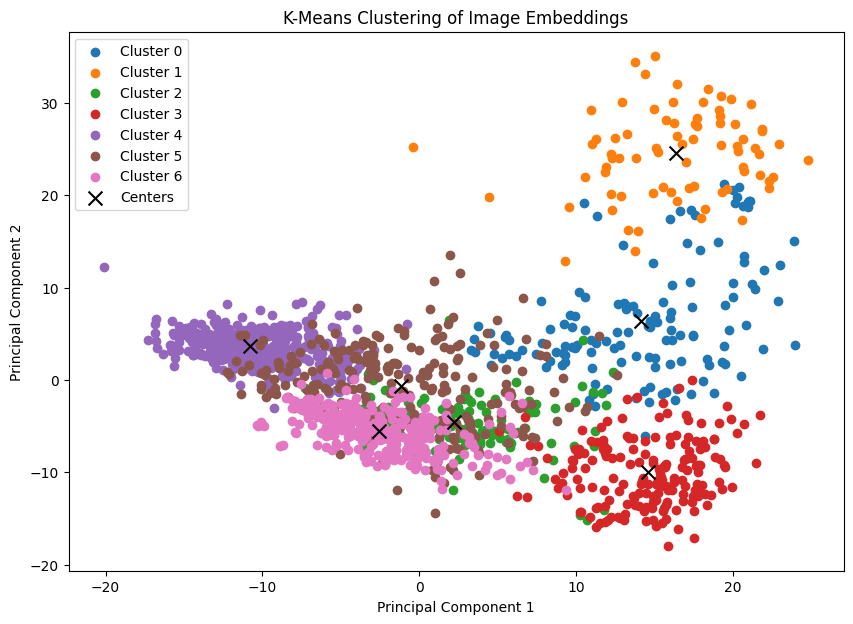

Cluster 0: 135 items copied to k_means_second_clustered_output/cluster_0
Cluster 1: 76 items copied to k_means_second_clustered_output/cluster_1
Cluster 2: 149 items copied to k_means_second_clustered_output/cluster_2
Cluster 3: 180 items copied to k_means_second_clustered_output/cluster_3
Cluster 4: 466 items copied to k_means_second_clustered_output/cluster_4
Cluster 5: 250 items copied to k_means_second_clustered_output/cluster_5
Cluster 6: 320 items copied to k_means_second_clustered_output/cluster_6
Cluster center 0 saved to k_means_second_clustered_output/cluster_center_0.txt
Cluster center 1 saved to k_means_second_clustered_output/cluster_center_1.txt
Cluster center 2 saved to k_means_second_clustered_output/cluster_center_2.txt
Cluster center 3 saved to k_means_second_clustered_output/cluster_center_3.txt
Cluster center 4 saved to k_means_second_clustered_output/cluster_center_4.txt
Cluster center 5 saved to k_means_second_clustered_output/cluster_center_5.txt
Cluster center 6

In [47]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 设置嵌入文件夹路径和原图像文件夹路径
embedding_dir = f"k_means_first_clustered_output/cluster_{best_cluster}/embedding"  # 替换为嵌入文件夹路径
image_dir = f"k_means_first_clustered_output/cluster_{best_cluster}/images"   # 替换为裁剪图像文件夹路径
output_cluster_dir = "k_means_second_clustered_output"  # 替换为聚类输出文件夹路径

# 创建输出文件夹
if not os.path.exists(output_cluster_dir):
    os.makedirs(output_cluster_dir)

# 加载嵌入
embeddings = []
file_names = []
for embedding_file in os.listdir(embedding_dir):
    if embedding_file.endswith(".txt"):
        embedding_path = os.path.join(embedding_dir, embedding_file)
        embedding = np.loadtxt(embedding_path)
        embeddings.append(embedding)
        file_names.append(os.path.splitext(embedding_file)[0])

embeddings = np.array(embeddings)

# 进行标准化处理
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# 使用PCA降维以便于可视化
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_scaled)

# 设置K-Means聚类的参数
num_clusters = 7 # 你可以调整聚类数量
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# 执行K-Means聚类
kmeans.fit(embeddings_scaled)
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

# 可视化聚类结果
plt.figure(figsize=(10, 7))
for i in range(num_clusters):
    cluster_indices = np.where(labels == i)[0]
    cluster_embeddings_2d = embeddings_2d[cluster_indices]
    plt.scatter(cluster_embeddings_2d[:, 0], cluster_embeddings_2d[:, 1], label=f'Cluster {i}')
plt.scatter(pca.transform(cluster_centers)[:, 0], pca.transform(cluster_centers)[:, 1], color='black', marker='x', s=100, label='Centers')
plt.legend()
plt.title("K-Means Clustering of Image Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# 创建每个聚类的文件夹并将嵌入和图像文件分别复制进去
for i in range(num_clusters):
    cluster_dir = os.path.join(output_cluster_dir, f"cluster_{i}")
    embedding_cluster_dir = os.path.join(cluster_dir, "embedding")
    image_cluster_dir = os.path.join(cluster_dir, "images")
    os.makedirs(embedding_cluster_dir, exist_ok=True)
    os.makedirs(image_cluster_dir, exist_ok=True)

    cluster_indices = np.where(labels == i)[0]
    for idx in cluster_indices:
        file_name = file_names[idx]

        # 复制嵌入文件
        src_embedding_path = os.path.join(embedding_dir, f"{file_name}.txt")
        dst_embedding_path = os.path.join(embedding_cluster_dir, f"{file_name}.txt")
        shutil.copyfile(src_embedding_path, dst_embedding_path)

        # 复制原图像文件
        src_image_path = os.path.join(image_dir, f"{file_name}.png")  # 假设图像扩展名为png，若有不同请更改
        dst_image_path = os.path.join(image_cluster_dir, f"{file_name}.png")
        if os.path.exists(src_image_path):
            shutil.copyfile(src_image_path, dst_image_path)

    print(f"Cluster {i}: {len(cluster_indices)} items copied to {cluster_dir}")

# 保存聚类中心到单独的文件
for i, center in enumerate(cluster_centers):
    center_file = os.path.join(output_cluster_dir, f"cluster_center_{i}.txt")
    np.savetxt(center_file, center)
    print(f"Cluster center {i} saved to {center_file}")

print("Clustering and file copying completed.")


In [48]:
new_embeddings_folder = 'cel_embedding'  # 替换为要分配的新嵌入文件夹路径
cluster_centers_dir = 'k_means_second_clustered_output'  # 替换为聚类中心嵌入文件夹路径
assign_folder_to_clusters(new_embeddings_folder, cluster_centers_dir, output_dir="k_means_assigned_clusters")

File dgm049_face_0.txt assigned to cluster cluster_4.
File dgm332_face_0.txt assigned to cluster cluster_4.


## KNN merge with DBSCAN

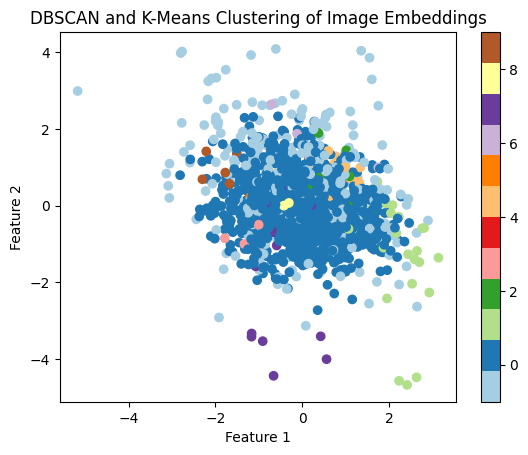

Cluster -1: 275 files saved to DBSCAN_KNN_res/cluster_-1
Cluster 0: 1205 files saved to DBSCAN_KNN_res/cluster_0
Cluster 1: 23 files saved to DBSCAN_KNN_res/cluster_1
Cluster 2: 15 files saved to DBSCAN_KNN_res/cluster_2
Cluster 3: 8 files saved to DBSCAN_KNN_res/cluster_3
Cluster 4: 10 files saved to DBSCAN_KNN_res/cluster_4
Cluster 5: 6 files saved to DBSCAN_KNN_res/cluster_5
Cluster 6: 6 files saved to DBSCAN_KNN_res/cluster_6
Cluster 7: 15 files saved to DBSCAN_KNN_res/cluster_7
Cluster 8: 7 files saved to DBSCAN_KNN_res/cluster_8
Cluster 9: 6 files saved to DBSCAN_KNN_res/cluster_9
DBSCAN clustering and file sorting completed.


In [49]:
import os
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import shutil

# Step 1: 读取所有嵌入
embeddings_dir = f"k_means_first_clustered_output/cluster_{best_cluster}/embedding"  # 替换为实际路径
images_dir = f"k_means_first_clustered_output/cluster_{best_cluster}/images"   # 替换为对应的图像文件夹路径
embeddings = []
file_names = []

for file_name in os.listdir(embeddings_dir):
    if file_name.endswith('.txt'):
        file_path = os.path.join(embeddings_dir, file_name)
        embedding = np.loadtxt(file_path)
        embeddings.append(embedding)
        file_names.append(file_name)

embeddings = np.array(embeddings)

# Step 2: 标准化嵌入
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# Step 3: 执行 DBSCAN 聚类
dbscan = DBSCAN(eps=26.8, min_samples=6)  # 可以调整 eps 和 min_samples 参数
clusters = dbscan.fit_predict(embeddings_scaled)

# Step 4: 可视化结果（仅适用于2D或通过PCA降维到2D的情况）
plt.scatter(embeddings_scaled[:, 0], embeddings_scaled[:, 1], c=clusters, cmap='Paired', marker='o')
plt.title('DBSCAN and K-Means Clustering of Image Embeddings')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar()
plt.show()

# Step 5: 将聚类结果的图片和嵌入分别保存到对应的文件夹中
output_dir = 'DBSCAN_KNN_res'  # 替换为实际路径
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for cluster_id in np.unique(clusters):
    cluster_dir = os.path.join(output_dir, f'cluster_{cluster_id}')
    embeddings_cluster_dir = os.path.join(cluster_dir, 'embeddings')
    images_cluster_dir = os.path.join(cluster_dir, 'images')
    
    os.makedirs(embeddings_cluster_dir, exist_ok=True)
    os.makedirs(images_cluster_dir, exist_ok=True)

    cluster_indices = np.where(clusters == cluster_id)[0]
    
    # 计算聚类中心
    cluster_embeddings = embeddings_scaled[cluster_indices]
    cluster_center = np.mean(cluster_embeddings, axis=0)
    
    # 保存聚类中心到文件
    cluster_center_path = os.path.join(output_dir, f'cluster_{cluster_id}_center.txt')
    np.savetxt(cluster_center_path, cluster_center)
    
    for index in cluster_indices:
        file_name = file_names[index]
        
        # 复制嵌入文件
        src_embedding_path = os.path.join(embeddings_dir, file_name)
        dst_embedding_path = os.path.join(embeddings_cluster_dir, file_name)
        shutil.copyfile(src_embedding_path, dst_embedding_path)

        # 复制对应的图像文件
        # 假设图像文件名与嵌入文件名相同，但扩展名不同
        image_file_name = file_name.replace('.txt', '.png')  # 替换扩展名
        src_image_path = os.path.join(images_dir, image_file_name)
        dst_image_path = os.path.join(images_cluster_dir, image_file_name)
        
        if os.path.exists(src_image_path):
            shutil.copyfile(src_image_path, dst_image_path)
        else:
            print(f"Image file not found for {file_name}")

    print(f"Cluster {cluster_id}: {len(cluster_indices)} files saved to {cluster_dir}")

print("DBSCAN clustering and file sorting completed.")


In [50]:
new_embeddings_folder = 'cel_embedding'
cluster_centers_dir = 'DBSCAN_KNN_res'
assign_folder_to_clusters(new_embeddings_folder, cluster_centers_dir, output_dir="DBSCAN_KNN_assigned_clusters")

File dgm049_face_0.txt assigned to cluster cluster_0.
File dgm332_face_0.txt assigned to cluster cluster_0.


## finding the most similar one based on Euclidean distance

In [52]:
import os
import numpy as np
from scipy.spatial.distance import euclidean

# 定义目录
cel_embeddings_dir = 'DBSCAN_KNN_assigned_clusters'  # 赛璐璐嵌入文件夹
clustered_embeddings_dir = 'DBSCAN_res'  # 聚类嵌入文件夹
output_file = 'matching_results.txt'  # 输出结果文件

# 找到分配到的聚类中最相似的嵌入
def find_most_similar(cel_embedding_file, cluster_dir):
    cel_embedding = np.loadtxt(cel_embedding_file)
    min_distance = float('inf')
    most_similar_file = None
    
    # 遍历聚类中的所有嵌入
    for embedding_file in os.listdir(cluster_dir):
        if embedding_file.endswith('.txt'):
            cluster_embedding = np.loadtxt(os.path.join(cluster_dir, embedding_file))
            distance = euclidean(cel_embedding, cluster_embedding)
            if distance < min_distance:
                min_distance = distance
                most_similar_file = embedding_file

    return most_similar_file, min_distance

# 保存匹配结果到文件
with open(output_file, 'w') as f:
    # 处理每个赛璐璐嵌入
    for cluster_id in os.listdir(cel_embeddings_dir):
        cluster_cel_dir = os.path.join(cel_embeddings_dir, cluster_id)
        cluster_embeddings_dir = os.path.join(clustered_embeddings_dir, cluster_id, 'embeddings')
        
        if os.path.isdir(cluster_cel_dir):
            for cel_file in os.listdir(cluster_cel_dir):
                if cel_file.endswith('.txt'):
                    cel_file_path = os.path.join(cluster_cel_dir, cel_file)
                    most_similar, distance = find_most_similar(cel_file_path, cluster_embeddings_dir)
                    
                    # 移除文件名中的 "face_0" 部分
                    cel_base_name = os.path.splitext(cel_file)[0].replace('_face_0', '')
                    most_similar_base_name = os.path.splitext(most_similar)[0].replace('_face_0', '')
                    
                    f.write(f"{cel_base_name} -> {most_similar_base_name}\n")
                    print(f"For cel {cel_base_name} in cluster {cluster_id}, the most similar embedding is {most_similar_base_name} with a distance of {distance}")

print(f"Matching results saved to {output_file}")


For cel dgm049 in cluster cluster_0, the most similar embedding is frame_01834 with a distance of 10.870655361736388
For cel dgm332 in cluster cluster_0, the most similar embedding is frame_06092 with a distance of 10.692859303240345
Matching results saved to matching_results.txt


In [ ]:
import os
import numpy as np
from scipy.spatial.distance import euclidean

# 定义路径
matching_results_file = 'matching_results.txt'
image_dir = 'embeddings'  # 假设所有帧图像都在此目录下
cel_embeddings_dir = 'cel_embedding'  # 赛璐璐嵌入文件夹

# 查找指定范围内的帧文件
def find_nearby_frames(base_frame_name, range_size=50):
    frame_number = int(base_frame_name.split('_')[1])
    nearby_frames = []
    for i in range(frame_number - range_size, frame_number + range_size + 1):
        nearby_frame_name = f"frame_{str(i).zfill(5)}_face_0.txt"
        nearby_frames.append(nearby_frame_name)
    return nearby_frames

# 查找最相似的帧
def find_most_similar_in_range(cel_embedding, nearby_frames, frame_dir):
    min_distance = float('inf')
    most_similar_frame = None
    for frame_file in nearby_frames:
        frame_path = os.path.join(frame_dir, frame_file)
        if os.path.exists(frame_path):
            frame_embedding = np.loadtxt(frame_path)
            distance = euclidean(cel_embedding, frame_embedding)
            if distance < min_distance:
                min_distance = distance
                most_similar_frame = frame_file
    return most_similar_frame, min_distance

# 读取匹配结果文件并查找最相似帧的邻近帧
with open(matching_results_file, 'r') as f:
    for line in f:
        cel_name, matched_frame_name = line.strip().split(' -> ')
        matched_frame_base = matched_frame_name.split('_face_0')[0]
        
        # 获取赛璐璐嵌入
        cluster_id = [folder for folder in os.listdir(cel_embeddings_dir) if cel_name in os.listdir(os.path.join(cel_embeddings_dir, folder))][0]
        cel_embedding_path = os.path.join(cel_embeddings_dir, cluster_id, f"{cel_name}_face_0.txt")
        cel_embedding = np.loadtxt(cel_embedding_path)

        # 获取附近的帧文件名
        nearby_frames = find_nearby_frames(matched_frame_base)

        # 查找最相似的帧
        most_similar_frame, distance = find_most_similar_in_range(cel_embedding, nearby_frames, image_dir)
        
        print(f"For cel {cel_name}, the most similar frame in range is {most_similar_frame} with a distance of {distance}")
